# Master-Thesis 

Summary:  
Find mysterious soil property corresponding to soil-moisture behaviours. First Idea is to look at soil-moisture content after a minimum of 10 mm precipitation occured. Analyse the drying behaviours of the soil in the dry period after the rain event. 

# Table-of-content  

[AOI](#AOI)  



## Modul imports

In [27]:
import pprint
pp = pprint.PrettyPrinter(indent=2) # for printing pretty idk what it is... print with pp.pprint(print stuff)
import ipyleaflet
from ipyleaflet import Map, GeoJSON, basemaps, Popup, LayersControl
from ipywidgets import HTML
from IPython.display import Image, IFrame
import ee
ee.Initialize()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
from sklearn import cluster
from skimage import io, morphology, measure
from osgeo import gdal, gdal_array
gdal.UseExceptions()
gdal.AllRegister()


In [3]:
import os
import numpy as np


## Functions

In [4]:
#Get TileLayerurl from ee to plot on ipyleaflet
def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)


# AOI

The area of interest is the hessisches Ried. The shape is digitized from a screnshot taken from http://atlas.umwelt.hessen.de/servlet/Frame/atlas/naturschutz/naturraum/karten/m_3_2_1.htm . I found no better source. Info: The HLNUG is selling this shapes there's no open source map.

In [5]:
# Load AOI from GEE as FeatureCollection
ried_225_222 = ee.FeatureCollection('users/tillmueller1990/ried_225_222') # Use this but the boundary isn't that precise at borders, got it from wms layer 

#Get geometry and convert it to GeoJSON for visualisation purpose 
ried_geometry = ried_225_222.geometry().getInfo() #dict object
ried_geometry = ee.Geometry.Polygon(ried_geometry['coordinates']) #cast to Geometry object
ried_JSON = ried_geometry.toGeoJSON() #get GeoJSON object

#get area of aoi
ried_area = ried_225_222.geometry().area().getInfo()
print("Hessisches Ried: Naturräumliche Einheiten 225 und 222, area: ca. ", ried_area/1000**2, "km²") #m² in km² 

#map properties
center, zoom = (49.7252978589571, 8.34580993652344), 9

#create basemap
map = Map(center = center, zoom = zoom, basemap=basemaps.Esri.NatGeoWorldMap)

#add Layer to map
ried = GeoJSON(data = ried_JSON, style = {'color': 'blue', 'opacity':1, 'fillOpacity':0.25}) #Create GeoJSON ipyleaflet object
map.add_layer(ried) #add layer to map

#display map
map


Hessisches Ried: Naturräumliche Einheiten 225 und 222, area: ca.  725.892726964547 km²


Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

# Remote sensed data

This work try to obtain the most data from osm remotely sensed products or self derived data.  
There are many properties affecting soil moisture:  
1. Soil type  (X)
2. Organic content  ( )
3. Precipitation  (X)
4. Vegetation  (X)
5. Altitude  (X)
6. Sun radiation (X)
7. Cloudcover  ( )
8. Soil temperature (X)
9. Air temperature (X)
10. Evaporation / Evapotranspiration (X)
11. Wind relation (X)
12. ? ( )

A brief overview of available datasets:  

### Earth Engine Datasets
#### NASA-USDA Global Soil Moisture Data https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_soil_moisture
revesit : 3days ; resoltion : 0.25 arc degrees (~25km)
Surface soil moisture  
Subsurface soil moisture  
Soil moisture profile  
Surface soil moisture anomaly  
Subsurface soil moisture anomaly  
#### CHIRPS Daily: Climate Hazards Group InfraRed Precipitation with Station Data https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY
revesit : daily ; resolution : 0.05 arc degrees (~5km)  
precipitation mm 
####  GLDAS-2.1: Global Land Data Assimilation System https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V021_NOAH_G025_T3H
revesit : 3 H , resolotion : 0.25 arc degrees (~25km)  
Albedo  
Average surface skin temperature  
Plant canopy surface water  
Canopy water evaporation  
Direct evaporation from bare soil  
Evapotranspiration  
Downward long-wave radiation flux  
Net long-wave radiation flux  
Potential evaporation rate  
Pressure 
Specific humidity  
Heat flux  
Sensible heat net flux  
Latent heat net flux  
Storm surface runoff  
Baseflow-groundwater runoff  
Snow melt  
Total precipitation rat  
Rain precipitation rate  
Root zone soil moisture  
Snow depth water equivalent  
Downward short-wave radiation flux  
Snow depth  
Snow precipitation rate  
Soil moisture  
Soil temperature  
Net short wave radiation flux  
Air temperature  
Transpiration  
Wind speed  

### Other Datasets

#### Bodenübersichtskarte von Hessen http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de
Year: 1997, scale: 1 : 500 000 bis zu 1:5000 




# Soil Type
Soil type is important because different kind of soils have different potentials to release water at same weather conditions.   
![Image of Yaktocat](http://www.soilmanagementindia.com/wp-content/uploads/2017/03/clip_image002-5.jpg)  

I found no source for downloading a soil map in any format there are only wms layer and bodenviewer of HLNUG so i take a screenshot from HLNUG Bodenviewe.  
The smallest scale fits on one screenshot. The other two scales (1:50.000 and 1:5.000) need several screenshots. Than you have to stich the images with e.g. autosticht together.  

In [38]:
IFrame(src='http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de&center=550000%2C5595000%2C25832&lod=3', width=1400, height=600)

## All Band Classifier (KMeans)
Save this images as .tiff or .png to preserve the 3 bands. Because we need to make a KMeans classification and with more bands the classification is better. The number of possible soil classes are 32 + 1 for the white background. 

[[ 0  0  0 ...  0  0 32]
 [ 0  0  0 ...  0  0 32]
 [ 0  0  0 ...  0  0 32]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Color: [255. 255. 255.]  >>  Objects: 1
Color: [232. 192. 164.]  >>  Objects: 56
Color: [255. 196.  77.]  >>  Objects: 186
Color: [239. 210. 255.]  >>  Objects: 40
Color: [255. 225. 166.]  >>  Objects: 127
Color: [183. 230. 246.]  >>  Objects: 108
Color: [223. 161. 115.]  >>  Objects: 9
Color: [255. 197. 210.]  >>  Objects: 229
Color: [233. 157. 255.]  >>  Objects: 62
Color: [238. 222.  77.]  >>  Objects: 73
Color: [248. 217. 113.]  >>  Objects: 56
Color: [248. 162. 204.]  >>  Objects: 53
Color: [136. 255.  77.]  >>  Objects: 28
Color: [216. 210. 178.]  >>  Objects: 85
Color: [173. 140. 125.]  >>  Objects: 4
Color: [238. 183.  77.]  >>  Objects: 33
Color: [195. 155.  77.]  >>  Objects: 16
Color: [216. 174. 153.]  >>  Objects: 22
Color: [220. 220. 148.]  >>  Objects: 11
Color: [214. 122. 210.]  >>  Objects: 10
Color: [220. 220. 220.]

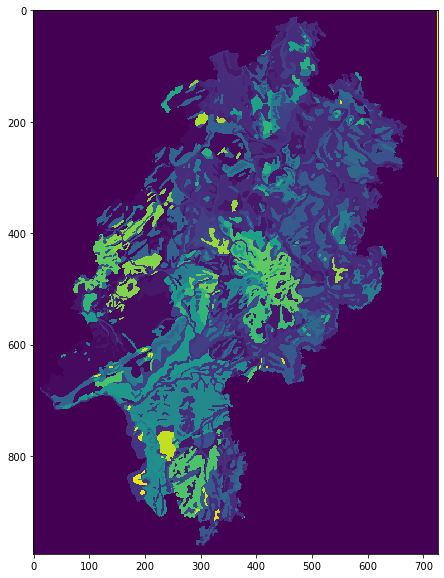

In [28]:
filepath = r'C:\Users\USER\Desktop\master-thesis-master\soil_map\results\great_hesse_soil_map_ref.tif'

#Load file in gdal
file = gdal.Open(filepath, gdal.GA_ReadOnly)

#Initialize an array of zeros with size of input
img = np.zeros((file.RasterYSize, file.RasterXSize, file.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(file.GetRasterBand(1).DataType))

#Loop over the number of bands in the image (img.shape[2]) insert values into the numpy array
for b in range(img.shape[2]):
    img[ : , : , b] = file.GetRasterBand(b + 1).ReadAsArray()

#Reshape array 
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

#based on this shape, we can build the input value
X = img[: , : , :3].reshape(new_shape)
#X = np.where(X==150, 255, X) Bad idea because other r ,g or b values may have same as black and gray
#X = np.where(X==0, 255, X) 

#Classifier Kmeans
k_means = cluster.KMeans(n_clusters=33)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

#Get statistic values
for i in np.unique(X_cluster):
    blobs = np.int_(morphology.binary_opening(X_cluster == i))
    color = np.around(k_means.cluster_centers_[i])
    count = len(np.unique(measure.label(blobs))) - 1
    print('Color: {}  >>  Objects: {}'.format(color, count))
    
#Plot the data
plt.figure(figsize=(20,10))
plt.imshow(X_cluster)

plt.show()


## Save Classification as GeoTiff 

In [ ]:
#Open input image again to get properties
file = gdal.Open(filepath)

#We need a single band
band = file.GetRasterBand(1)

#Convert it to an array
arr = band.ReadAsArray()

#Extract columns and rows to a list
[cols, rows] = arr.shape

#Set the output as Geotiff
format = "GTiff"
driver = gdal.GetDriverByName(format)

#Creates the output raster with the dimensions of the input raster
#outDataRaster = driver.Create("soil_map_hesse_classify_33.tiff", rows, cols, 1, gdal.GDT_Byte) -> activate this cell for saving image local

#Set the projection and extent of the data.
outDataRaster.SetGeoTransform(file.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(file.GetProjection())##sets same projection as input

#Write classification result to a single band raster image 
outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

#Calling FlushCache() to remove from memory and delete the data
outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)

## Analyse Soil Types within AOI

Create Features for different soil types to compare soil-moisture 

In [ ]:
#Load Soil Types from BÜK 1:500.000 and clip to AOI
soil_map_great = ee.Image('users/tillmueller1990/soil_map_hesse_classify_33').clip(ried_225_222)

#Mask out Background 
mask = soil_map_great.neq(1) #Value 1 is invalid its the background (white) from screenshot 
soil_map_great = soil_map_great.updateMask(mask) #Apply Mask

#Get Unique values to check if every value is signed correctly 
soil_map_great_uniqueValues = soil_map_great.reduceRegion(reducer=ee.Reducer.countDistinct(), geometry=ried_geometry, scale= 100 ,maxPixels= 1e10)
print("soil_map_great_uniqueValues", soil_map_great_uniqueValues.getInfo())

#Correct raster values to corresponding soil class values 
soil_map_great = soil_map_great.where(soil_map_great.eq(14),1) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(12),13) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(3),2) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(31),3) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(19),4) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(25),34) ## 
soil_map_great = soil_map_great.where(soil_map_great.eq(7),25) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(9),7) ## 
soil_map_great = soil_map_great.where(soil_map_great.eq(5),9) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(8),5) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(0),8) ##

#get area for each class
class_areas = ee.Image.pixelArea().divide(1000*1000).addBands(soil_map_great).reduceRegion(reducer= ee.Reducer.sum().group(groupField= 1,groupName= 'Soil class'),geometry=ried_geometry,scale= 265, maxPixels= 1e10).get('groups') # sample the geometry at 1m intervals;
pp.pprint(class_areas.getInfo())

#Convert an image to a feature collection by reducing homogenous regions
soil_map_great_labeled = soil_map_great.connectedComponents(ee.Kernel.plus(1),250) #Finds connected components with the same value of the first band of the input and labels them with a globally unique value.
soil_map_great_scale = soil_map_great_labeled.projection().nominalScale().getInfo() #get scale parameter 
features = soil_map_great_labeled.reduceToVectors(reducer = ee.Reducer.first(), geometry= ried_geometry, scale= 265, geometryType= 'Polygon', eightConnected= False,maxPixels= 1e10) #FeatureCollection of patches

def add_area_to_FC(feature):
    return feature.set('area',  feature.geometry().area(1).divide(1000*1000))

features = features.map(add_area_to_FC)
pp.pprint(features.getInfo())

#Grouped a count reducer: count number of land cover category pixels by patches
count = soil_map_great_labeled.select(['labels','b1']).reduceRegion(reducer= ee.Reducer.count().group(groupField= 0, groupName= 'label'), geometry= ried_geometry, scale= 265,  maxPixels= 1e8)
pp.pprint(count.getInfo())

#Get test field for biggest area of soil class
class_1 = features.filterMetadata('label','equals',)

#Create LookUp Table for raster values corresponding to the soil type 
soil_types_legend = {1:'Niedermoore, Hochmoore', 2:'Vega, Auengleye, örtl. Anmoorgleye', 3:'Tschernoseme', 4:'Parabraunerden', 5:'Braunerden mit Bändern, Bänder-Parabraunerden, örtl. Podsol-Braunerden', 7:'Pararendzinen, Braunerden mit Bändern, örtl. Bänder-Parabraunerden', 8:'Braunerden mit Bändern, Bänder-Parabraunerden, örtl. Podsol-Braunerden', 9:'Pararendzinen', 13: 'Parabraunerden, örtl. Pseudogley-Parabraunerden',25: 'Braunerden, Ranker-Braunerden, Regosol-Braunerden' , 34 : 'Braunerden, Braunerde-Pseudogleye, örtl. Podsol-Braunerden'} #Legende
raster_value_soil_value = {14:1, 3:2, 31:3, 19:4, 25:34, 7:25, 9:7 ,8:5, 9:7 , 0:8, 5:9 } # Value in raster value of legend



soil_map_great_uniqueValues {'b1': 12}
[ {'Soil class': 1, 'sum': 54.134680807843544},
  {'Soil class': 2, 'sum': 167.6488250538931},
  {'Soil class': 3, 'sum': 32.093248070312406},
  {'Soil class': 4, 'sum': 178.89962462814134},
  {'Soil class': 5, 'sum': 113.95033903416072},
  {'Soil class': 7, 'sum': 83.83647987366727},
  {'Soil class': 8, 'sum': 53.012483863281744},
  {'Soil class': 9, 'sum': 18.597190235692402},
  {'Soil class': 13, 'sum': 1.0604802034160539},
  {'Soil class': 25, 'sum': 5.034909453446693},
  {'Soil class': 34, 'sum': 17.59305870199146}]
{ 'columns': { 'area': 'Number',
               'first': 'Short<0, 255>',
               'label': 'Long',
               'system:index': 'String'},
  'features': [ { 'geometry': { 'coordinates': [ [ [ 8.37966583224207,
                                                     49.93552215847389],
                                                   [ 8.37969642756382,
                                                     49.93313884700188]

In [26]:
#create basemap
map_s = Map(center = center, zoom = zoom, basemap=basemaps.Esri.NatGeoWorldMap)

#soil color map
soil_color = {1:'87FF4B', 2:'B5E6F5', 3:'D8A56D', 4:'C1994B', 5:'EDB74B', 7:'FFD1EE', 8:'FFE0A5', 9:'E99DFF',13:'FFBA43',25:'FFC3D1',34:'EECEA1'}
#add Layer to map
soil_map_great_viz = GetTileLayerUrl(soil_map_great.visualize(min=0, max=9)) #Create GeoJSON ipyleaflet object
soil_map_great_layer = ipyleaflet.TileLayer(url=soil_map_great_viz,name='soil_map_great')

soil_map_great_patches_viz = GetTileLayerUrl(features.draw(color= '006600').visualize())
soil_map_great_patches_layer = ipyleaflet.TileLayer(url=soil_map_great_patches_viz, name='soil_class features')

map_s.add_layer(soil_map_great_layer) #add layer to map
map_s.add_layer(soil_map_great_patches_layer) #add layer to map

#display map
map_s.add_control(LayersControl())
map_s

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

soil_map_great_histogram {1.0: 773.7843137254902, 2.0: 2385.023529411763, 3.0: 459.0, 4.0: 2549.854901960784, 5.0: 1612.2980392156862, 7.0: 1190.8549019607844, 8.0: 760.5921568627449, 9.0: 264.87450980392157, 13.0: 14.529411764705882, 25.0: 69.15686274509805, 34.0: 249.26666666666662}


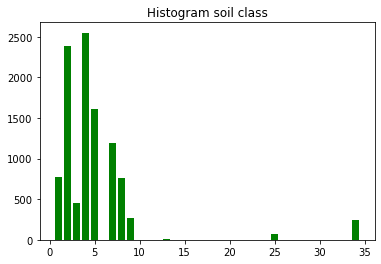

In [22]:
#Make Histogram
def get_histogram_from_image(image):
    dict_histogram = image.reduceRegion(reducer=ee.Reducer.autoHistogram(), geometry=ried_geometry, scale= 265,maxPixels= 1e10).getInfo()['b1']
    keys = [x[0] for x in dict_histogram if x[1] > 0.0]  #get keys from [key,value] list if value is > 0
    values = [x[1] for x in dict_histogram if x[0] in keys] #get values for keys if the key is in value
    return dict(zip(keys,values))

histogram_soil_map_great = get_histogram_from_image(soil_map_great)
print("soil_map_great_histogram", histogram_soil_map_great)

plt.bar(histogram_soil_map_great.keys(), histogram_soil_map_great.values(), color='g')
plt.title("Histogram soil class")
plt.show()

In [39]:
#ried_viz = GetTileLayerUrl(ried_225_222.visualize())
#In order to analyse the soil-moisture content we need to know more about the landuse and landcover. We are interested in fields with less or no vegetation.   




['labels', 'b1']
{ 'groups': [ {'count': 503, 'patch id': 2005749729182},
              {'count': 6766, 'patch id': 2005749729185},
              {'count': 7, 'patch id': 2010044696476},
              {'count': 127, 'patch id': 2014339663770},
              {'count': 200, 'patch id': 2104533977025},
              {'count': 519, 'patch id': 2130303780806},
              {'count': 467, 'patch id': 2207613192426},
              {'count': 3164, 'patch id': 2211908159388},
              {'count': 1560, 'patch id': 2220498093978},
              {'count': 6, 'patch id': 2220498094266},
              {'count': 550, 'patch id': 2229088028633},
              {'count': 2006, 'patch id': 2263447767181},
              {'count': 552, 'patch id': 2263447767223},
              {'count': 852, 'patch id': 2276332669101},
              {'count': 6568, 'patch id': 2319282341985},
              {'count': 46, 'patch id': 2357937047494},
              {'count': 716, 'patch id': 2357937047502},
              